In [1]:
# 기본 라이브러리 임포트
import pandas as pd             
import numpy as np             
import matplotlib.pyplot as plt 
import seaborn as sns           
import gc                       # 가비지 컬렉션(메모리 해제)
import re                       # 정규 표현식 처리
from collections import defaultdict  # 기본값이 있는 딕셔너리 생성

# 경고 메시지 억제
import warnings
warnings.filterwarnings('ignore')   

# 그래프 스타일 설정
sns.set()                           # seaborn 기본 스타일 적용

# matplotlib 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
# plt.rcParams['font.family'] = 'AppleGothic'  
plt.rcParams['figure.figsize'] = (12, 6)       # 그림 크기 설정 (가로, 세로)
plt.rcParams['font.size'] = 14                 # 폰트 크기 설정
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# 결측치 시각화 라이브러리 임포트
import missingno                          # 결측치 분포를 시각화하는 유틸리티

# 범주형 변수 레이블 인코딩을 위한 도구 임포트
from sklearn.preprocessing import LabelEncoder

# 중복 조합 생성에 사용할 product 함수 임포트
from itertools import product

# 회귀 및 통계 분석을 위한 statsmodels 임포트
import statsmodels.api as sm

# 다중공선성 진단용 VIF 계산 함수 임포트
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv ('train_cleaned7.csv')
df

,기준년월,ID,컨택건수_이용유도_EM_B0M,컨택건수_이용유도_TM_R6M,컨택건수_이용유도_EM_R6M,Segment
0,201807,TRAIN_000000,13,3,57,D
1,201807,TRAIN_000001,0,2,2,E
2,201807,TRAIN_000002,0,2,12,C
3,201807,TRAIN_000003,13,2,35,D
4,201807,TRAIN_000004,0,7,0,E
...,...,...,...,...,...,...
2399995,201812,TRAIN_399995,0,0,0,E
2399996,201812,TRAIN_399996,13,0,58,D
2399997,201812,TRAIN_399997,0,0,0,C
2399998,201812,TRAIN_399998,0,0,0,E


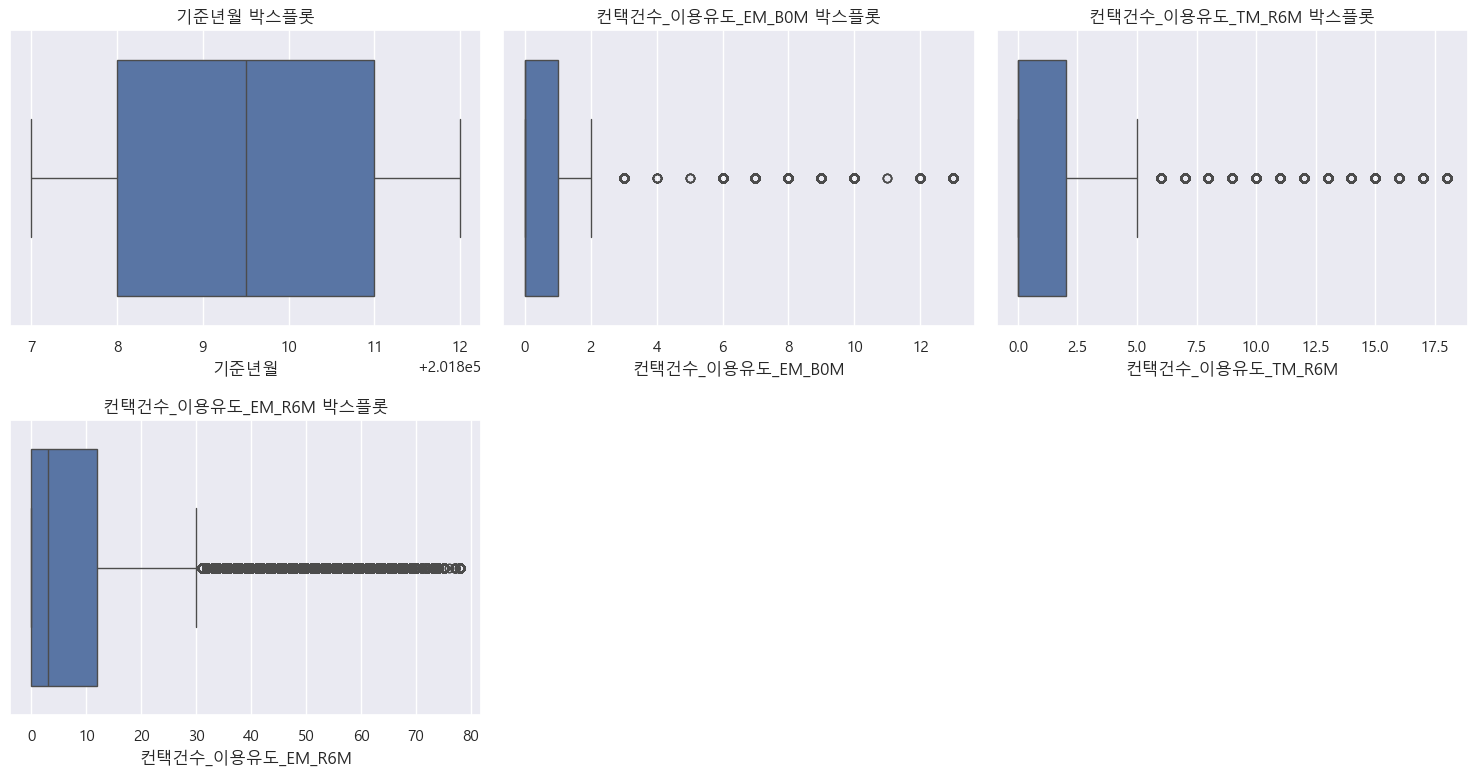

In [3]:
# 수치형 컬럼 중 ID 컬럼 제외
num_cols = df.drop(columns=['ID']).select_dtypes(include='number').columns.tolist()

# 생성: 박스플롯을 위한 서브플롯 그리드 설정
n = len(num_cols)
cols = 3
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

# 그리기: 각 수치형 컬럼에 대한 박스플롯(이상치·극단치 시각화)
for ax, col in zip(axes, num_cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"{col} 박스플롯")
# 빈 서브플롯 숨기기
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

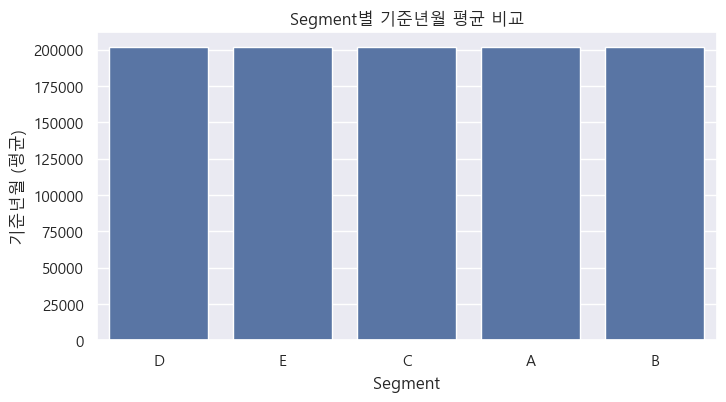

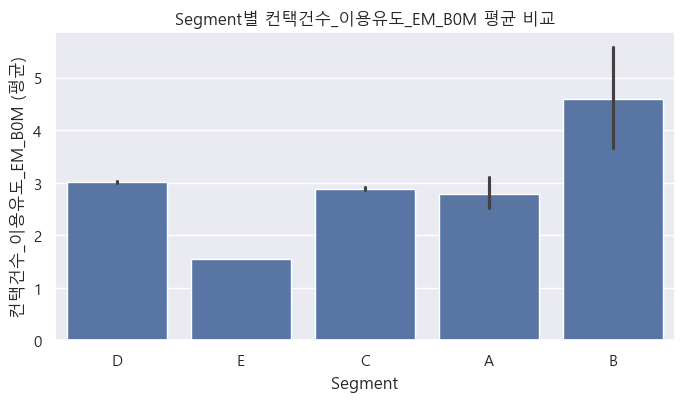

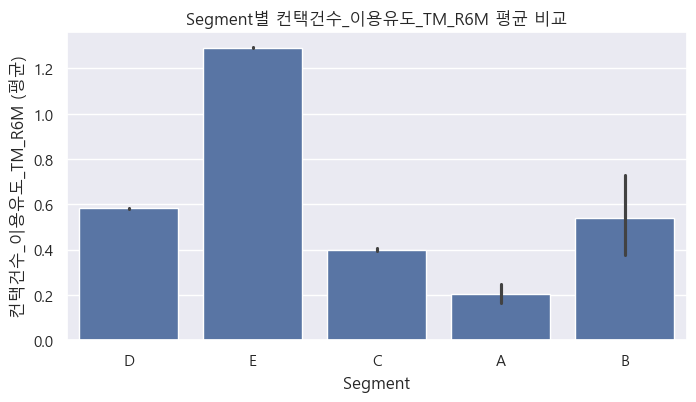

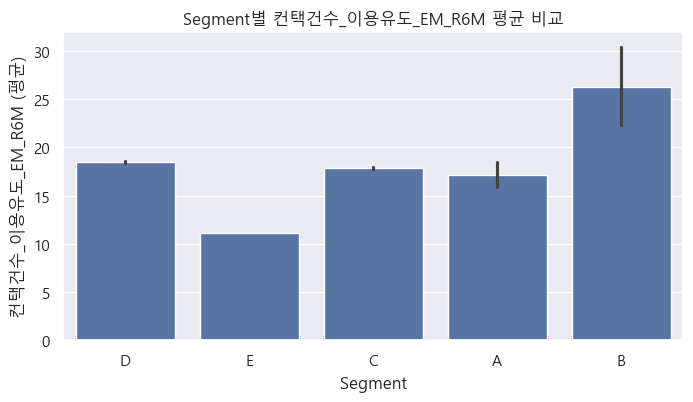

In [4]:
# 수치형 컬럼 중 ID 컬럼 제외
num_cols = df.drop(columns=['ID']).select_dtypes(include='number').columns.tolist()

# 반복: 각 컬럼별 Segment 대비 평균 바플롯
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Segment', y=col, data=df, estimator=np.mean)
    plt.title(f"Segment별 {col} 평균 비교")
    plt.xlabel("Segment")
    plt.ylabel(f"{col} (평균)")
    plt.show()

## 그래프별 세그먼트 비교 및 해석

| Segment | EM_B0M (최근 이벤트 기본 접촉) | TM_R6M (최근 6개월 텔레마케팅) | EM_R6M (최근 6개월 이벤트) |
|:-------:|:-----------------------------:|:-----------------------------:|:--------------------------:|
| **B**   | 약 4.6회 — 최고 수준          | 약 0.5회 — 보통 이하          | 약 26회 — 압도적 최고      |
| **C**   | 약 2.9회 — 중상위             | 약 0.4회 — 낮은 편            | 약 18회 — 상위             |
| **A**   | 약 2.8회 — 중간               | 약 0.2회 — 최저급             | 약 17회 — 중간             |
| **D**   | 약 3.0회 — 중상위             | 약 0.6회 — 중간 상위          | 약 19회 — 중상위           |
| **E**   | 약 1.5회 — 최저               | 약 1.3회 — 최고 수준          | 약 11회 — 최저             |

---

## 종합 해석

**B**  
– 이벤트 마케팅에 가장 활발히 반응 (EM_B0M·EM_R6M 모두 최고)  
– 텔레마케팅 반응은 보통 수준 → 이벤트 중심 추가 캠페인 강화  

**C**  
– 이벤트 참여는 높은 편 (EM_R6M 상위)  
– 텔레마케팅 반응 저조 → 비전화 채널(이메일·앱 푸시) 집중  

**A**  
– 전반적 반응 보통 수준 → 균형형 마케팅 전략  
– 소규모 파일럿 캠페인으로 리소스 최적화  

**D**  
– 이벤트 반응 중상위, 텔레마케팅은 중간 → 혼합 채널 시너지 활용  
– 이벤트 후 텔레콜 후속 유도 프로세스 강화  

**E**  
– 텔레마케팅만 반응 우수, 이벤트 참여 및 기본 접촉은 최저 → 콜 중심 리인게이지먼트  
– 이벤트·이메일 리마인더로 추가 접촉 유도  